In [ ]:
!pip install adjustText

In [ ]:
################################
###  Read Passwords Dataset  ###
################################

import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/Shareddrives/ENLP Final Projects - Passwords/autoencoder/data/1000passwords.csv"

passwords = pd.read_csv(path, dtype={'Numeric': str})
print(passwords)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
    Capital   Word Numeric Special FullPassword
0         A   cafe    2019       !   Acafe2019!
1         A  hyper    2019       !  Ahyper2019!
2         P   leet      10       !     Pleet10!
3         A   babe       2       !      Ababe2!
4         T  bingo    1234       *  Tbingo1234*
..      ...    ...     ...     ...          ...
995       A   leet     123       !    Aleet123!
996       A  hyper     777       !   Ahyper777!
997       P   cafe     123       *    Pcafe123*
998       A   cafe      10       %     Acafe10%
999       A   babe     101       _    Ababe101_

[1000 rows x 5 columns]


In [ ]:
##################################
###  Pad & Tokenize Passwords  ###
##################################
from keras.utils import to_categorical
from keras.preprocessing import sequence

# Identify max password length in dataset and pad rest of the passwords such that all of them have the same length.
# Haveing same length sequences is a requirement for LSTM
PAD_CHAR = "~"
PASS_LENGTH = max([len(p) for p in passwords["FullPassword"]])

padded_passwords = []
charset = set(PAD_CHAR)               # start with the initial padding char
for p in passwords["FullPassword"]:
  padded_passwords.append(p.ljust(PASS_LENGTH, PAD_CHAR))
  charset |= set(p)                   # |= is the union set operation.

# Convert characters to integers 
vocab_size = len(charset)
char2id = dict((c, i) for i, c in enumerate(charset))

# One hot encode the passwords
encoded_passwords = [[char2id[c] for c in password] for password in padded_passwords]
one_hot_encoded = np.array([to_categorical(p, num_classes=vocab_size) for p in encoded_passwords])

# Standard Autoencoders

In [ ]:
##################################
###  Create Autoencoder Model  ###
##################################
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, Bidirectional
from keras.models import Model

def create_lstm_autoencoder(timesteps, layer_sizes, vocab_size):
  """
  Creates a symmetric LSTM autoencoder model and returns, the autoencoder model, encoder model,
  and decoder model to be used individually.
  """
  # Create encoder model
  enc_input = Input(shape=(timesteps, vocab_size))
  x = enc_input
  for idx, layer_size in enumerate(layer_sizes):
    ret_seq = (idx != len(layer_sizes) - 1) # False for the last layer_size
    x = Bidirectional(LSTM(layer_size, return_sequences=ret_seq))(x)
  enc_output = Dense(layer_sizes[-1], activation="relu")(x)
  encoder = Model(enc_input, enc_output, name="Encoder")

  # Create decoder model
  bottleneck_size = layer_sizes[-1]
  dec_input = Input((bottleneck_size,))
  x = RepeatVector(timesteps)(dec_input)
  for layer_size in layer_sizes[::-1][1:]:
    x = Bidirectional(LSTM(layer_size, return_sequences=True))(x)
  dec_output = TimeDistributed(Dense(vocab_size, activation="softmax"))(x)
  decoder = Model(dec_input, dec_output, name="Decoder")

  # Connect decoder with encoder
  connected_decoder = decoder(enc_output)

  # Create autoencoder model
  autoencoder = Model(enc_input, connected_decoder, name="Autoencoder")
  autoencoder.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
  return encoder, decoder, autoencoder

In [ ]:
encoder, decoder, autoencoder = create_lstm_autoencoder(PASS_LENGTH, [16, 10, 6], vocab_size)
encoder.summary()
decoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 15, 38)]          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 15, 32)            7040      
_________________________________________________________________
bidirectional_6 (Bidirection (None, 15, 20)            3440      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 12)                1296      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
Total params: 11,854
Trainable params: 11,854
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Sh

In [ ]:
#####################
###  Train Model  ###
#####################

autoencoder.fit(one_hot_encoded, one_hot_encoded, epochs=300, batch_size=10)

Epoch 1/300
100/100 [==============================] - 46s 50ms/step - loss: 3.2518 - accuracy: 0.3128
Epoch 2/300
100/100 [==============================] - 5s 51ms/step - loss: 2.2191 - accuracy: 0.4231
Epoch 3/300
100/100 [==============================] - 5s 51ms/step - loss: 1.8478 - accuracy: 0.4811
Epoch 4/300
100/100 [==============================] - 5s 51ms/step - loss: 1.6621 - accuracy: 0.4866
Epoch 5/300
100/100 [==============================] - 5s 52ms/step - loss: 1.5266 - accuracy: 0.5034
Epoch 6/300
100/100 [==============================] - 5s 52ms/step - loss: 1.4251 - accuracy: 0.5312
Epoch 7/300
100/100 [==============================] - 5s 51ms/step - loss: 1.3408 - accuracy: 0.5675
Epoch 8/300
100/100 [==============================] - 5s 51ms/step - loss: 1.2639 - accuracy: 0.5902
Epoch 9/300
100/100 [==============================] - 5s 51ms/step - loss: 1.1753 - accuracy: 0.6165
Epoch 10/300
100/100 [==============================] - 5s 51ms/step - loss: 1.10

In [ ]:
# Recosntruct passwords through autoencoder as vectors
reconst_passwd_vecs = autoencoder.predict(one_hot_encoded)
# Reverse one hot encoding to covnert passwords to strings
unpad = lambda text: text.replace(PAD_CHAR, "")
one_hot_decode = lambda one_hot_vectors: "".join([list(charset)[np.argmax(vec)] for vec in one_hot_vectors])
reconst_passwd_str = [unpad(one_hot_decode(p)) for p in reconst_passwd_vecs]

In [ ]:
# Compare original vs reconstructed passwords
passwords_df = pd.DataFrame(zip(passwords["FullPassword"], reconst_passwd_str),
                            columns = ['Original Password', 'Recosntructed Password'])
passwords_df.head(10)

,Original Password,Recosntructed Password
0,Acafe2019!,Acafe2019!
1,Ahyper2019!,Ahyper2019!
2,Pleet10!,Aleet10!
3,Ababe2!,Ababe2!
4,Tbingo1234*,Abingo1234*
5,Eleet2019@,Aleet2019@
6,Tninja123!,Aninja123!
7,Aninja777*,Aninja777*
8,Ababe101*,Ababe101*
9,Tbingo2019_,Abingo2019_


In [ ]:
################################
###  Generate New Passwords  ###
################################
import random

# Feel free to change the latent space values as you like and explore what comes
# out from the decoder
new_passwords = []
for _ in range(20):
  latent_sample = np.array([[random.uniform(-1, 1) for _ in range(6)]])
  new_password_vec = decoder.predict(latent_sample)
  new_password_str = unpad(one_hot_decode(new_password_vec[0]))
  new_passwords.append(new_password_str)
new_passwords_df = pd.DataFrame(new_passwords, columns=["Password"])
new_passwords_df.head(10)

,Password
0,Ahyper000*
1,Ahacknnnnny7$
2,ccckerm!
3,hhacerrr!
4,Ahackrr9m*
5,hhhhceerr
6,Ahayk9nnaaa
7,Ahyper1
8,Aaab000000
9,ccyffe0000a


Plotting t-SNE visualization...


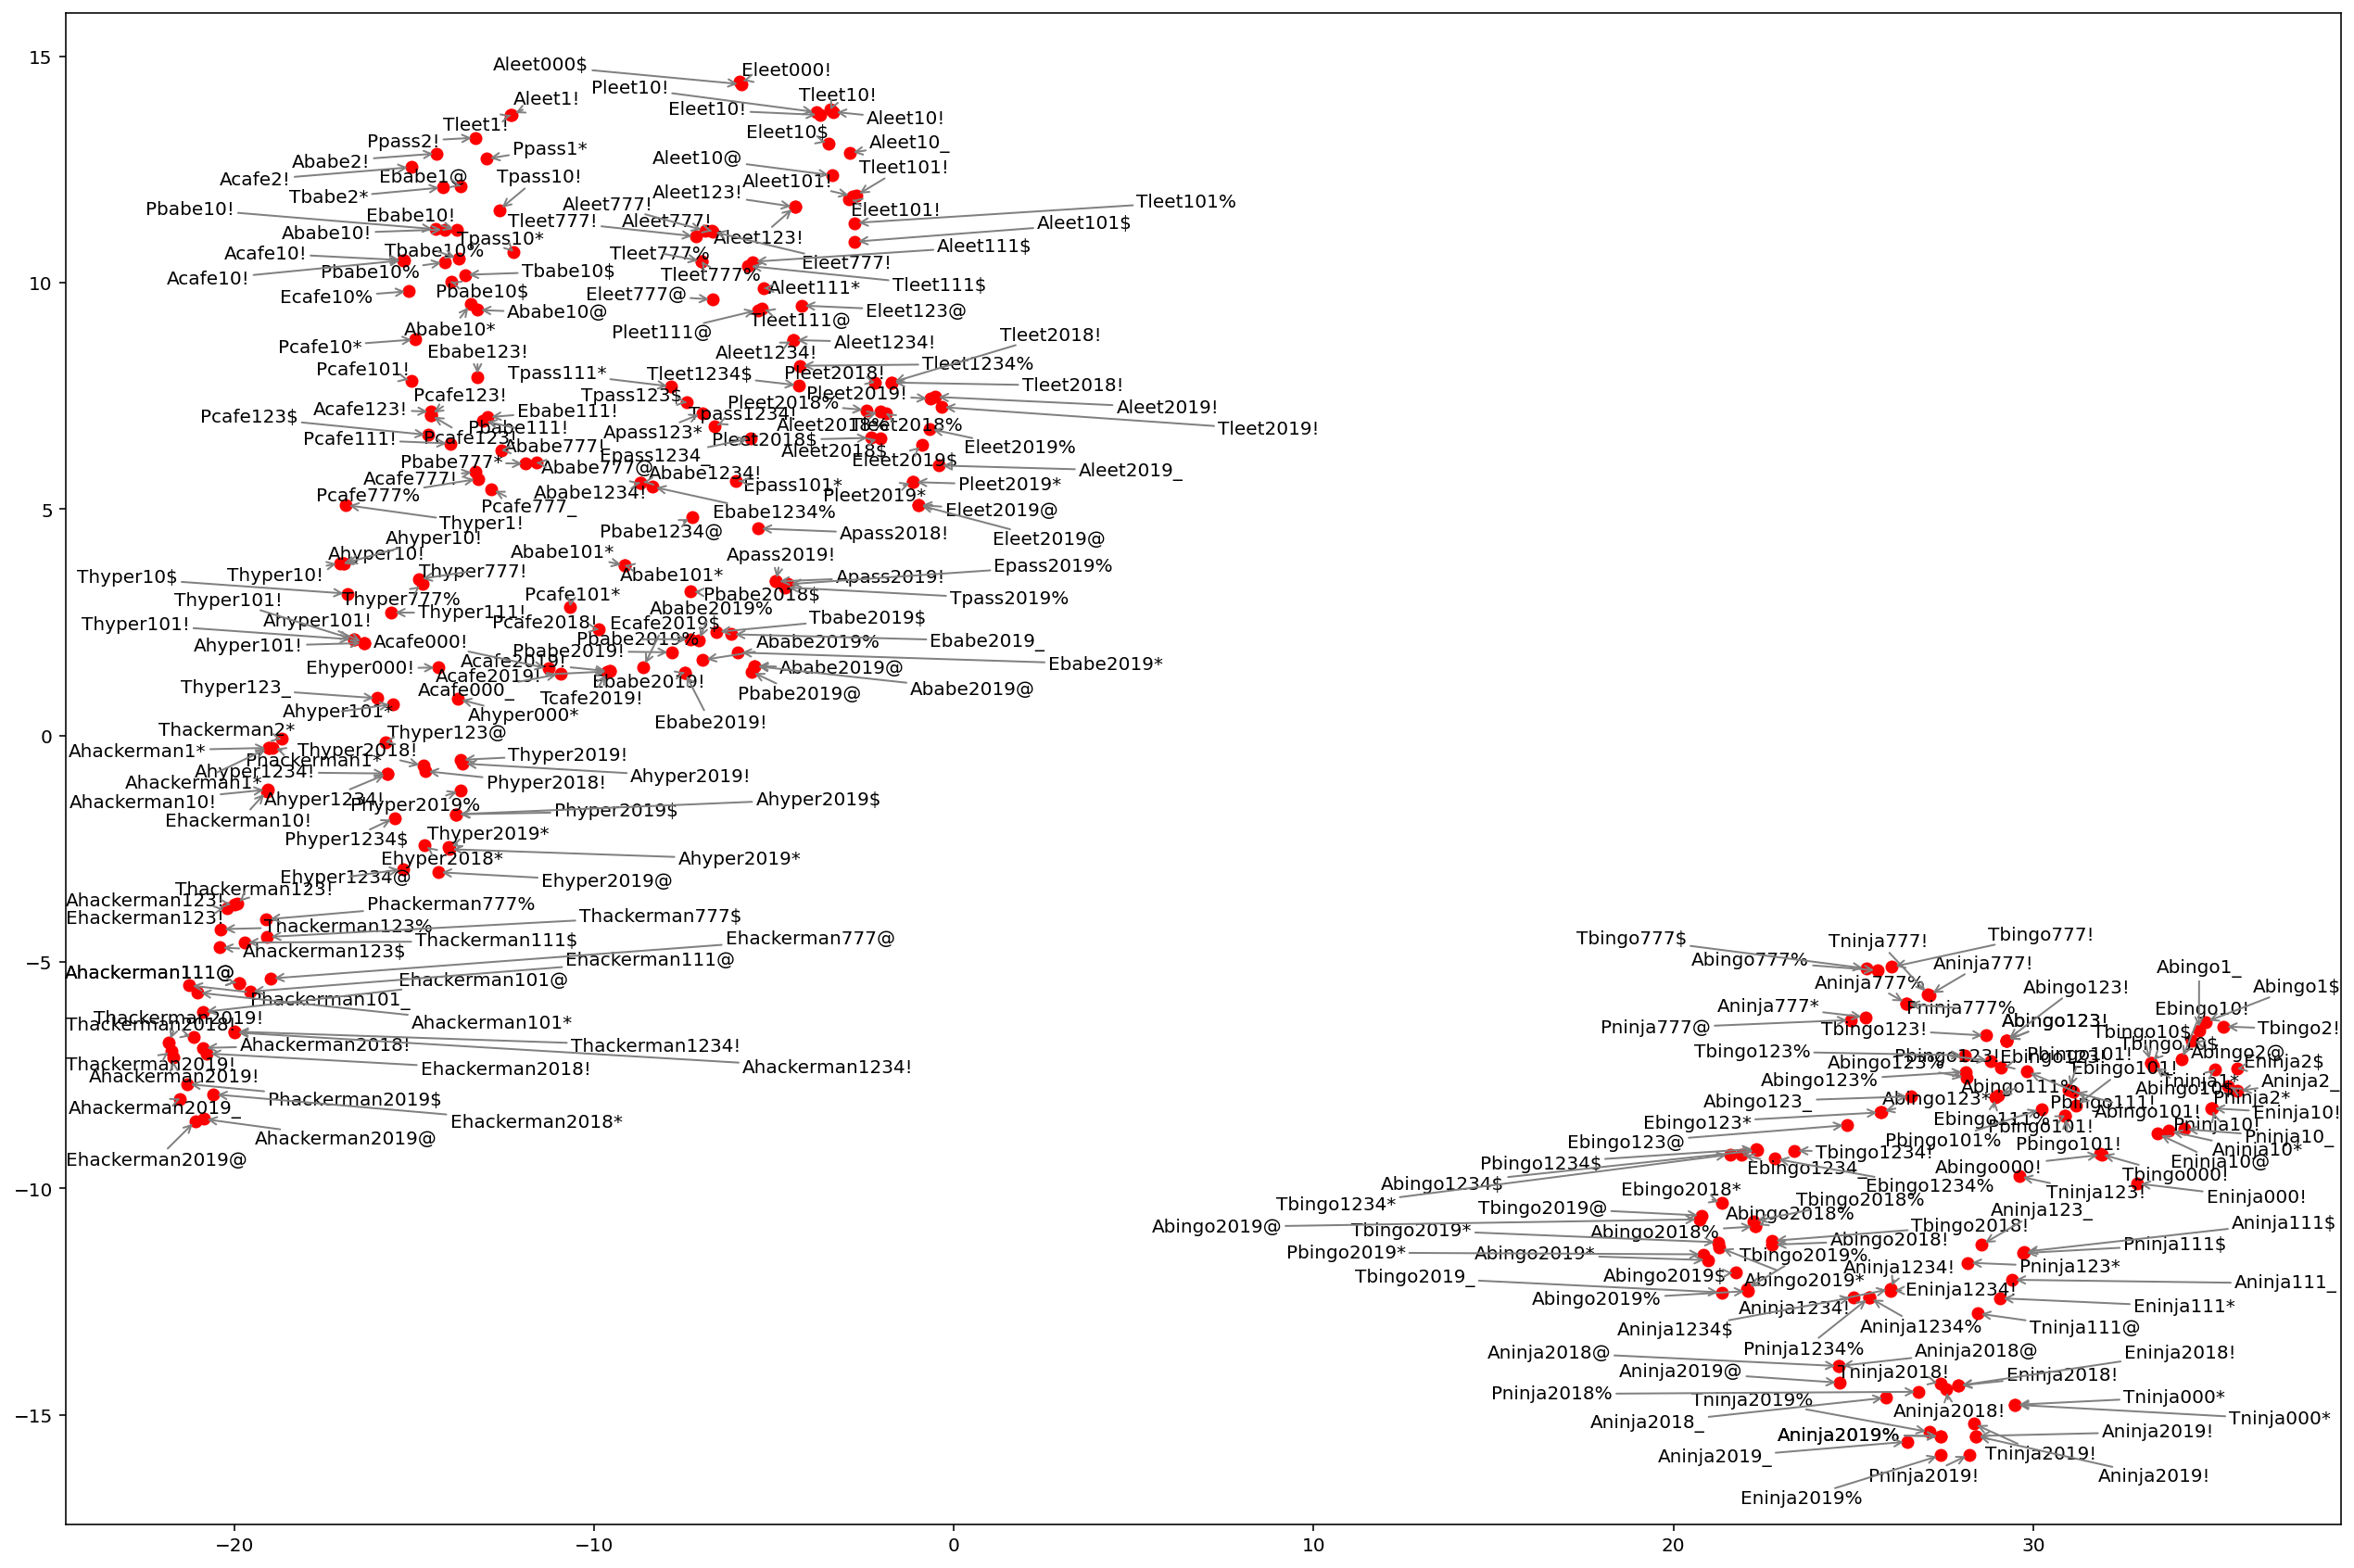

In [ ]:
#############################################
###  Visualize Passowrds in Latent Space  ###
#############################################
%config InlineBackend.figure_format = 'retina'

from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, AnnotationBbox
from sklearn import manifold

def t_sne(latent_passwords, original_passwords, plot=True):
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(latent_passwords)
    if plot:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=(22,15))
        plt.plot(X_tsne[:, 0], X_tsne[:, 1], 'ro')
        texts = [plt.text(X_tsne[:, 0][i], X_tsne[:, 1][i], '%s' %original_passwords[i], ha='center', va='center') for i in range(len(original_passwords))]
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))
        plt.show()
    else:
        return X_tsne, tsne

limit = 300
latent_passwords = encoder.predict(one_hot_encoded[:limit])
t_sne(latent_passwords, passwords["FullPassword"][:limit])